In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.io import loadmat
import scipy
%matplotlib inline



In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Sat Apr 13 20:02:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
"""
Copyright (c) Facebook, Inc. and its affiliates.
This source code is licensed under the MIT license found in the
LICENSE file in the root directory of this source tree.
"""

import torch
from torch import nn
from torch.nn import functional as F


class ConvBlock(nn.Module):
    """
    A Convolutional Block that consists of two convolution layers each followed by
    instance normalization, LeakyReLU activation and dropout.
    """

    def __init__(self, in_chans, out_chans, drop_prob):
        """
        Args:
            in_chans (int): Number of channels in the input.
            out_chans (int): Number of channels in the output.
            drop_prob (float): Dropout probability.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.drop_prob = drop_prob

        self.layers = nn.Sequential(
            nn.Conv2d(in_chans, out_chans, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm2d(out_chans),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout2d(drop_prob),
            nn.Conv2d(out_chans, out_chans, kernel_size=3, padding=1, bias=False),
            nn.InstanceNorm2d(out_chans),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout2d(drop_prob)
        )

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]
        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        return self.layers(input)


class TransposeConvBlock(nn.Module):
    """
    A Transpose Convolutional Block that consists of one convolution transpose layers followed by
    instance normalization and LeakyReLU activation.
    """

    def __init__(self, in_chans, out_chans):
        """
        Args:
            in_chans (int): Number of channels in the input.
            out_chans (int): Number of channels in the output.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans

        self.layers = nn.Sequential(
            nn.ConvTranspose2d(in_chans, out_chans, kernel_size=2, stride=2, bias=False),
            nn.InstanceNorm2d(out_chans),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]
        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        return self.layers(input)

class ZerosNet(nn.Module):
    def __init__(self):
        super(ZerosNet, self).__init__()

    def forward(self, input):
        return input*0.0 + 0.0

class UnetModel(nn.Module):
    """
    PyTorch implementation of a U-Net model.
    This is based on:
        Olaf Ronneberger, Philipp Fischer, and Thomas Brox. U-net: Convolutional networks
        for biomedical image segmentation. In International Conference on Medical image
        computing and computer-assisted intervention, pages 234–241. Springer, 2015.
    """

    def __init__(self, in_chans, out_chans, chans, num_pool_layers, drop_prob):
        """
        Args:
            in_chans (int): Number of channels in the input to the U-Net model.
            out_chans (int): Number of channels in the output to the U-Net model.
            chans (int): Number of output channels of the first convolution layer.
            num_pool_layers (int): Number of down-sampling and up-sampling layers.
            drop_prob (float): Dropout probability.
        """
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.chans = chans
        self.num_pool_layers = num_pool_layers
        self.drop_prob = drop_prob

        self.down_sample_layers = nn.ModuleList([ConvBlock(in_chans, chans, drop_prob)])
        ch = chans
        for i in range(num_pool_layers - 1):
            self.down_sample_layers += [ConvBlock(ch, ch * 2, drop_prob)]
            ch *= 2
        self.conv = ConvBlock(ch, ch * 2, drop_prob)

        self.up_conv = nn.ModuleList()
        self.up_transpose_conv = nn.ModuleList()
        for i in range(num_pool_layers - 1):
            self.up_transpose_conv += [TransposeConvBlock(ch * 2, ch)]
            self.up_conv += [ConvBlock(ch * 2, ch, drop_prob)]
            ch //= 2

        self.up_transpose_conv += [TransposeConvBlock(ch * 2, ch)]
        self.up_conv += [
            nn.Sequential(
                ConvBlock(ch * 2, ch, drop_prob),
                nn.Conv2d(ch, self.out_chans, kernel_size=1, stride=1),
            )]

        self.res = nn.Conv2d(in_chans+out_chans, out_chans, kernel_size=1, padding=0, bias=False)

    def forward(self, input):
        """
        Args:
            input (torch.Tensor): Input tensor of shape [batch_size, self.in_chans, height, width]
        Returns:
            (torch.Tensor): Output tensor of shape [batch_size, self.out_chans, height, width]
        """
        stack = []
        output = input

        # Apply down-sampling layers
        for i, layer in enumerate(self.down_sample_layers):
            output = layer(output)
            stack.append(output)
            output = F.avg_pool2d(output, kernel_size=2, stride=2, padding=0)

        output = self.conv(output)

        # Apply up-sampling layers
        for transpose_conv, conv in zip(self.up_transpose_conv, self.up_conv):
            downsample_layer = stack.pop()
            output = transpose_conv(output)

            # Reflect pad on the right/botton if needed to handle odd input dimensions.
            padding = [0, 0, 0, 0]
            if output.shape[-1] != downsample_layer.shape[-1]:
                padding[1] = 1  # Padding right
            if output.shape[-2] != downsample_layer.shape[-2]:
                padding[3] = 1  # Padding bottom
            if sum(padding) != 0:
                output = F.pad(output, padding, "reflect")

            output = torch.cat([output, downsample_layer], dim=1)
            output = conv(output)

        #concatentate input and output, perform 1x1 convolution (modification by Greg Ongie)
        output = self.res(torch.cat([input,output], dim=1))

        return output

In [ ]:
model = UnetModel(in_chans=1, out_chans=1, num_pool_layers=4, drop_prob=0.0, chans=32)
model = model.to(device) #send to GPU

#model = torch.load('/content/drive/MyDrive/MarquetteDr/Summer2023/walnut/pythonDL/denoiser_net.pt')
#model.eval()

#model = torch.load('/content/drive/MyDrive/MarquetteDr/Summer2023/walnut/pythonDL/denoiser_net_random_noise.pt')
#model.eval()

#model = torch.load('/content/drive/MyDrive/MarquetteDr/Summer2023/walnut/pythonDL/denoiser_net_AtA_preconditioned_m.pt')
#model.eval()

model = torch.load('/content/drive/MyDrive/MarquetteDr/Summer2023/walnut/pythonDL/denoiser_net_AtA_02122024.pt')#,map_location=torch.device('cpu'))
model.eval()

UnetModel(
  (down_sample_layers): ModuleList(
    (0): ConvBlock(
      (layers): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Dropout2d(p=0.0, inplace=False)
        (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (5): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (6): LeakyReLU(negative_slope=0.2, inplace=True)
        (7): Dropout2d(p=0.0, inplace=False)
      )
    )
    (1): ConvBlock(
      (layers): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Dro

In [ ]:

# Load the measurement matrix and sinogram from file Data164.mat
# Load data from MATLAB file
mat_data = loadmat('/content/drive/MyDrive/MarquetteDr/Summer2023/walnut/Data328.mat')
A = mat_data['A']
m = mat_data['m']

# Proximal Gradient Descent
lambda_val = 0.3

# Define functions
def f(x):
    return 0.5 * np.linalg.norm(A @ x - m.ravel('F'))**2 + lambda_val * np.linalg.norm(x, 1)

def grad(x):
    return np.transpose(A) @ (A @ x - m.ravel('F'))

def sigma(s, mu):
    return np.maximum(np.abs(s) - mu, 0) * np.sign(s)

# Initialize parameters
x0 = np.zeros(A.shape[1])
n = A.shape[1]
tolerance = 1e-3
L = 625.6242  # normest(A.T @ A)

# Proximal gradient descent
def proximal_grad(A, x0, n, lambda_val, f, grad, sigma, tolerance, L,a,m):
    tau = 1 / L
    res = scipy.sparse.linalg.lsqr(A,m.ravel('F'),iter_lim=15)

    x0 = res[0].reshape((int(np.sqrt(n)),int( np.sqrt(n))))
    x0 = np.transpose(x0)
    tol = tolerance  # Convergence tolerance
    x_k = x0.copy()
    alpha = a
    #print(x_k.shape)
    # Main loop
    for k in range(tol):
        z_k = x_k.ravel('F') - (tau*grad(x_k.ravel('F')))

        my_img = z_k.reshape((int(np.sqrt(n)),int( np.sqrt(n))))
        my_img = torch.from_numpy(my_img).to(device).float()
        with torch.no_grad():
          x_k_new  = my_img+model(my_img[None,None,:])[0][0].detach() #unet estimate

        x_k = (1-alpha)*x_k + np.transpose(alpha*x_k_new.cpu().numpy())
        #print(f(x_k.ravel('F')))

    return x_k,0 #, cost

# Run proximal gradient descent
iter = 10
alpha = 0.0008
#x, cost = proximal_grad(A, x0, n, lambda_val, f, grad, sigma,iter , L,alpha,m)

In [ ]:
import time

8.466576368181473


(-0.5, 327.5, 327.5, -0.5)

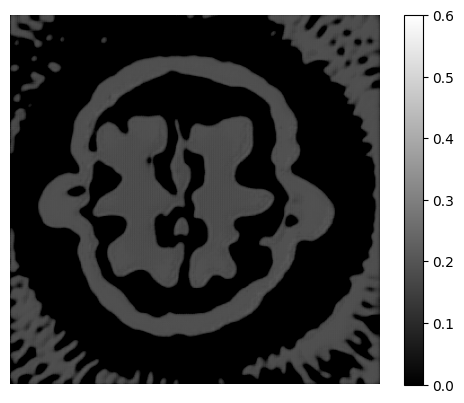

In [ ]:
# After tunning
#[0.0005, 100, 0.000557236686138909](1e-5)
#[0.0006, 80, 0.0005437882653305064](1e-5)
#[0.005, 70, 0.004662970806908272] with more noise (1e-4)
iter = 10#np.array((range(1,11)))*10
alpha = 0.5#0.0005*np.array(range(1,6))

# RESULTS GOT WAY BETTER DOING THE FOLLOWING


mmax = max(m.ravel('F'))
FN = "/content/drive/MyDrive/MarquetteDr/Summer2023/walnut/pythonDL/breast_phantom_512.npy" #put in path to file in drive
images = np.load(FN, mmap_mode = "r") #1000 images
train_images = images[:800] #training set
test_images = images[800:] #test set

images = test_images[0]
to_reshape = torch.from_numpy(images).to(device)
reshaped = torch.nn.functional.interpolate(to_reshape[None,None,:], (328,328))[0][0].detach()

images = reshaped.cpu()
images = images.numpy()

measurement = A@(images.ravel('F'))
mesmax = max(measurement.ravel('F'))
print(mesmax/mmax)
m_scaled = m*mesmax/mmax
#counter = 1
#for i in iter:
#  for j in alpha:
    #print(counter)
    #counter = counter+1
    #print(round(j,5))
    #print(i)
#    print('-----------------------------')
x, cost = proximal_grad(A, x0, n, lambda_val, f, grad, sigma,iter , L,alpha,m_scaled)
plt.imshow(x.reshape((int(np.sqrt(n)),int( np.sqrt(n)))), cmap='gray',vmin=0,vmax=0.6)
plt.colorbar()
plt.axis('off')

Text(0.5, 1.0, 'alpha: 0.0008, iter: 10')

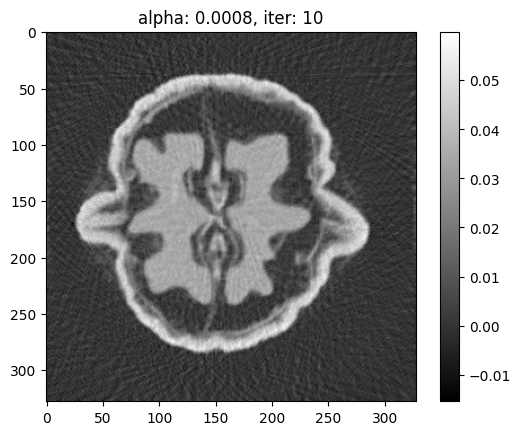

In [ ]:
# Plot results
import matplotlib.pyplot as plt

plt.imshow(x.reshape((int(np.sqrt(n)),int( np.sqrt(n)))), cmap='gray',vmin=0,vmax=0.06)
plt.colorbar()
plt.savefig('/content/drive/MyDrive/MarquetteDr/Summer2023/walnut/results/CNN/pdg_CNN_alpha_'+str(alpha)+'iter'+str(iter)+'.png')
plt.title('alpha: '+str(alpha)+', iter: '+str(iter))
#plt.close()

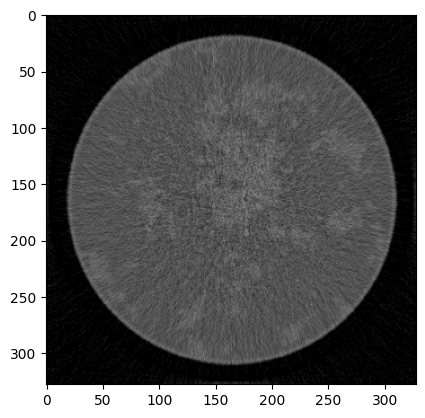

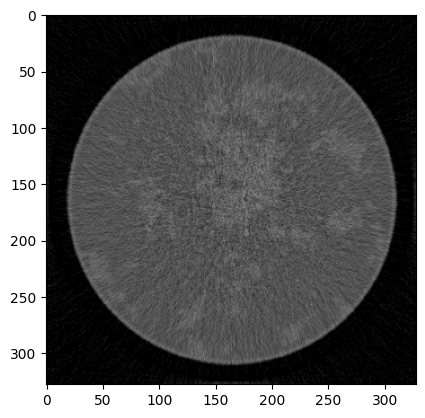

In [ ]:

random.seed(1)
sig=1e-5#---1e-6


FN = "/content/drive/MyDrive/MarquetteDr/Summer2023/walnut/pythonDL/breast_phantom_512.npy" #put in path to file in drive
images = np.load(FN, mmap_mode = "r") #1000 images
train_images = images[:800] #training set
test_images = images[800:] #test set

images = test_images[0]


to_reshape = torch.from_numpy(images).to(device)
reshaped = torch.nn.functional.interpolate(to_reshape[None,None,:], (328,328))[0][0].detach()

images = reshaped.cpu()
images = images.numpy()

measurement = A@(images.ravel('F'))

datavar = sig*np.exp(measurement)
m_0 = np.random.normal(measurement,np.sqrt(datavar)) # noisy measurement

alpha = 0.001*np.array(range(1,10))
iter = np.array((range(5,11)))*10
param_tun = []

# LOOK CPU vs GPU


res_x = scipy.sparse.linalg.lsqr(A,m_0.ravel('F'),iter_lim=15)
res_x = res_x[0].reshape((int(np.sqrt(n)),int( np.sqrt(n))))
res_x = res_x.transpose()
plt.figure()
plt.imshow(res_x, cmap='gray',vmin=0,vmax=0.6)


noisy_img = torch.from_numpy(res_x).to(device).float()
for i in range(1,100):
  with torch.no_grad():
    noisy_img  =  noisy_img + 150*model(noisy_img[None,None,:])[0][0].detach() #unet estimate

plt.figure()
plt.imshow(res_x, cmap='gray',vmin=0,vmax=0.6)

#min_index = min(range(len(param_tun)), key=lambda i: param_tun[i][2])

#print(param_tun[min_index])

# TRY reschaling walnut to match more the walnut (multiply m by 10?) compare the ratio of max greyscale - rescale walnut by max of phatoms

In [ ]:
#[0.0005, 100, 0.000557236686138909]
#[0.0006, 80, 0.0005437882653305064]
#[0.001, 50, 0.0005603062348599365]

8.466576368181473


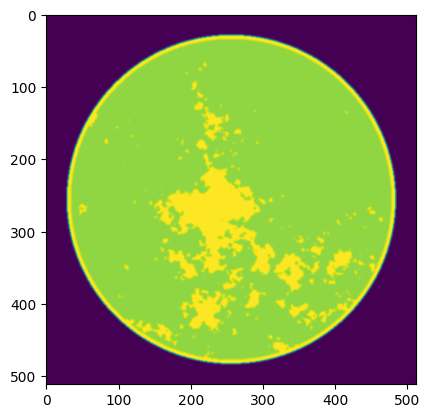

In [ ]:
mmax = max(m.ravel('F'))
FN = "/content/drive/MyDrive/MarquetteDr/Summer2023/walnut/pythonDL/breast_phantom_512.npy" #put in path to file in drive
images = np.load(FN, mmap_mode = "r") #1000 images
train_images = images[:800] #training set
test_images = images[800:] #test set

images = test_images[0]
to_reshape = torch.from_numpy(images).to(device)
reshaped = torch.nn.functional.interpolate(to_reshape[None,None,:], (328,328))[0][0].detach()

images = reshaped.cpu()
images = images.numpy()

measurement = A@(images.ravel('F'))
mesmax = max(measurement.ravel('F'))
print(mesmax/mmax)
m_scaled = m*mesmax/mmax

plt.imshow(train_images[2])


198.39354828219592

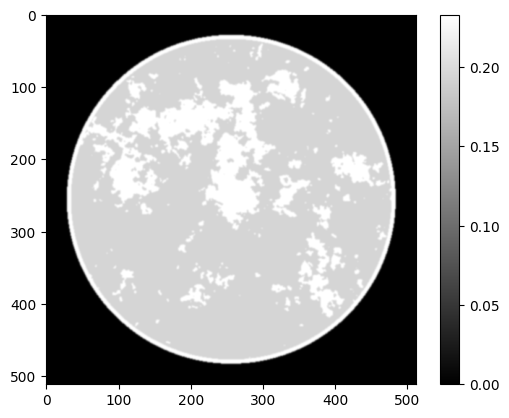

In [ ]:
plt.imshow(train_images[0], cmap='gray')
plt.colorbar()

In [ ]:
# DO IT FOR 2-Norm

# Load the measurement matrix and sinogram from file Data164.mat
# Load data from MATLAB file
mat_data = loadmat('/content/drive/MyDrive/MarquetteDr/Summer2023/walnut/Data328.mat')
A = mat_data['A']
m = mat_data['m']

In [ ]:
print(m.ravel('F').shape)
#np.concatenate((a,b), axis=0)
b=np.zeros((39360))
y=np.concatenate((m.ravel('F'),b))
print(y.shape)
print(A.shape)
lamb = 0.001
#sqrt_lamb = lamb**(1/2)*np.identity(A.shape)
import numpy as np
id = np.eye(39360, 107584)
print(id.shape)


(39360,)
(78720,)
(39360, 107584)
(39360, 107584)


In [ ]:
id = 2*id

In [ ]:
#B = np.concatenate((A, id), axis=1)
#B = scipy.sparse.vstack((A,id))
#print(B.shape)
res = scipy.sparse.linalg.lsqr(A,m.ravel('F'),damp=0.0001)
res1 = scipy.sparse.linalg.lsqr(A,m.ravel('F'),damp=0.0006)
res2 = scipy.sparse.linalg.lsqr(A,m.ravel('F'),damp=0.001)


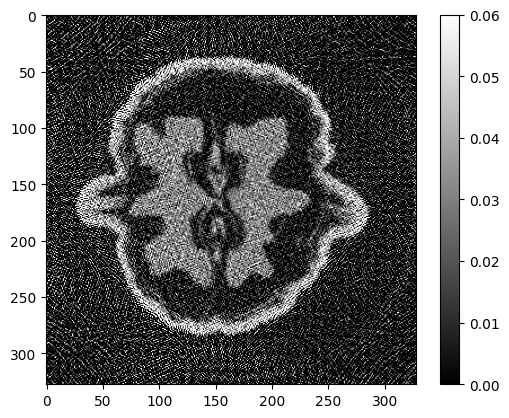

In [ ]:
A = mat_data['A']
m = mat_data['m']
res = scipy.sparse.linalg.lsqr(A,m.ravel('F'),damp=0.0001,iter_lim=100)
x1 = res[0].reshape((328,328))
x1 = np.transpose(x1)
plt.imshow(x1, cmap='gray',vmin=0,vmax=0.06)
plt.colorbar()
plt.show()

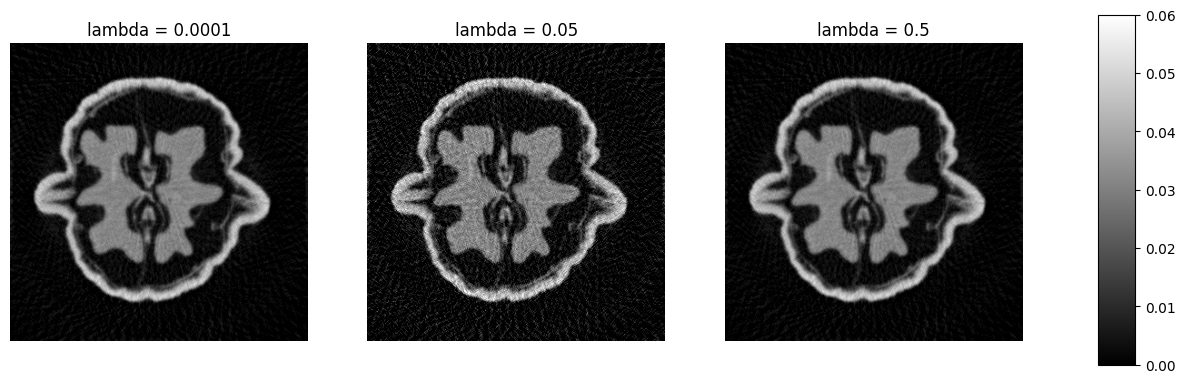

In [ ]:
plt.close()
res = scipy.sparse.linalg.lsqr(A,m.ravel('F'),damp=0.1,iter_lim=10)
res1 = scipy.sparse.linalg.lsqr(A,m.ravel('F'),damp=0.2,iter_lim=20)
res2 = scipy.sparse.linalg.lsqr(A,m.ravel('F'),damp=0.3,iter_lim=30)
#res = scipy.sparse.linalg.lsqr(A,m.ravel('F'),iter_lim=15)
x0 = res[0].reshape((328,328))
x0 = np.transpose(x0)

x1 = res1[0].reshape((328,328))
x1 = np.transpose(x1)

x2 = res2[0].reshape((328,328))
x2 = np.transpose(x2)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(x0, cmap='gray',vmin=0,vmax=0.06)
axs[0].axis('off')
axs[0].set_title('lambda = 0.0001')
axs[1].imshow(x1, cmap='gray',vmin=0,vmax=0.06)
axs[1].axis('off')
axs[1].set_title('lambda = 0.05')
axs[2].imshow(x2, cmap='gray',vmin=0,vmax=0.06)
axs[2].set_title('lambda = 0.5')
axs[2].axis('off')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
fig.colorbar(axs[2].imshow(x0, cmap='gray', vmin=0, vmax=0.06), cax=cbar_ax)

# Display the figure
plt.show()

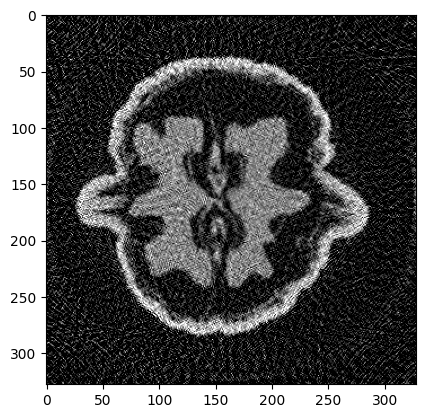

In [ ]:
plt.imshow(x0, cmap='gray',vmin=0,vmax=0.06)

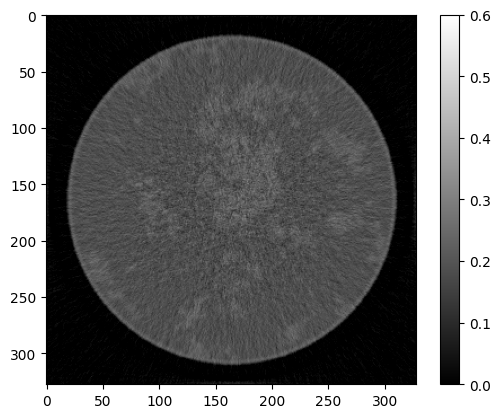

In [ ]:
plt.imshow(x.reshape((int(np.sqrt(n)),int( np.sqrt(n)))), cmap='gray',vmin=0,vmax=0.6)
plt.colorbar()